In [5]:
from config.configuration import engine
from tools import idealista_functions as i_func
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns

In [27]:
mysql_df = pd.read_sql_query(
f"""
SELECT sq_mt_built, 
        n_rooms, 
        n_bathrooms, 
        apartments.latitude, 
        apartments.longitude, 
        is_new_development, 
        is_renewal_needed, 
        has_lift, 
        is_exterior, 
        has_parking, 
        floor, 
        house_type_id,
        value_m2,
        neighborhood_name,
        district_name,
        buy_price
FROM apartments
LEFT JOIN neighborhoods
ON apartments.neighborhood_id = neighborhoods.neighborhood_id
LEFT JOIN districts
ON neighborhoods.district_id = districts.district_id
ORDER BY apartment_id DESC;
""", engine)

In [28]:
# Let's rename two columns:

mysql_df = mysql_df.rename(columns = {
    "neighborhood_name": "neighborhood",
    "district_name": "district"
       })

In [29]:
mysql_df["log_buy_price"] = np.log10(mysql_df.buy_price)

In [20]:
mysql_df.head()

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,floor,house_type_id,value_m2,neighborhood,district,buy_price,log_buy_price
0,51.0,1,1,40.3472,-3.70438,1,0,1,1,1,3.0,0,1617.18,San Andrés,Villaverde,163000.0,5.212188
1,98.0,2,2,40.3606,-3.69252,1,0,1,1,1,0.0,0,1827.79,Los Rosales,Villaverde,294900.0,5.469675
2,110.0,3,2,40.3663,-3.68527,0,0,1,1,1,1.0,0,1912.80,San Fermín,Usera,239000.0,5.378398
3,64.0,3,1,40.3550,-3.69355,0,0,1,1,0,1.0,0,1796.68,Los Ángeles,Villaverde,115100.0,5.061075
4,95.0,3,1,40.3628,-3.69888,0,0,1,1,0,3.0,0,1796.68,Los Ángeles,Villaverde,152000.0,5.181844


In [30]:
# Export data to CSV:

mysql_df.to_csv("./data/mysql_df_log.csv", index = False)

In [31]:
# Droping columns innecesary columns

mysql_df.drop("buy_price", axis=1, inplace=True)

In [33]:
mysql_df.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'latitude', 'longitude',
       'is_new_development', 'is_renewal_needed', 'has_lift', 'is_exterior',
       'has_parking', 'floor', 'house_type_id', 'value_m2', 'neighborhood',
       'district', 'log_buy_price'],
      dtype='object')

In [6]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,14 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_ccastrob_6xso7y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.963 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [37]:
# Let's split data:

h2o_df = h2o.H2OFrame(mysql_df)
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.8])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [38]:
y_cols = "log_buy_price"
X_cols = train_h2o.drop("log_buy_price", axis=1).columns

In [39]:
automl = H2OAutoML(max_models=250, max_runtime_secs=6000)
automl.train(x=X_cols, y=y_cols, training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████Failed polling AutoML progress log: Unexpected HTTP error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
█████████████| 100%


In [40]:
lb = automl.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20210728_185537_model_16,0.00572694,0.0756765,0.00572694,0.0558204,0.0115426
GBM_grid__1_AutoML_20210728_185537_model_25,0.00586993,0.0766155,0.00586993,0.0560973,0.0116792
GBM_grid__1_AutoML_20210728_185537_model_29,0.00587707,0.076662,0.00587707,0.0562192,0.0116837
XGBoost_grid__1_AutoML_20210728_185537_model_26,0.00591612,0.0769163,0.00591612,0.056948,0.0117409
GBM_grid__1_AutoML_20210728_185537_model_8,0.00592494,0.0769737,0.00592494,0.0559579,0.0117446
GBM_grid__1_AutoML_20210728_185537_model_60,0.00592944,0.0770029,0.00592944,0.0566777,0.0117477
XGBoost_grid__1_AutoML_20210728_185537_model_13,0.0059327,0.077024,0.0059327,0.0568652,0.0117601
GBM_grid__1_AutoML_20210728_185537_model_93,0.0059337,0.0770305,0.0059337,0.0560842,0.0117454
GBM_grid__1_AutoML_20210728_185537_model_72,0.00593578,0.077044,0.00593578,0.0558951,0.0117511
XGBoost_grid__1_AutoML_20210728_185537_model_8,0.00593615,0.0770464,0.00593615,0.0563745,0.0117731


In [4]:
model_path = h2o.save_model(model=automl.leader, path="../models", force=True)
print(model_path)

NameError: name 'automl' is not defined

#### Testing model:

In [42]:
token = i_func.get_idealista_token()

In [44]:
latitude = 40.45827074567995
longitude = -3.6907973233431846
latlon = str(latitude) + "," + str(longitude)

In [45]:
result = i_func.idealista_request(token, latlon, 2000)

In [47]:
df_mysql, df_pred = i_func.creating_dataframe(result)

In [53]:
df_pred = df_pred.rename(columns = {
"house_type": "house_type_id"
   })

In [54]:
df_pred.head()

,sq_mt_built,n_rooms,n_bathrooms,latitude,longitude,buy_price,is_new_development,is_renewal_needed,has_lift,is_exterior,has_parking,floor,house_type_id,value_m2,neighborhood,district
0,182.0,3,3,40.470755,-3.676347,1400000.0,0,0,1,1,1,1.0,0,4354.35,Castilla,Chamartín
1,246.0,3,3,40.466451,-3.675714,795000.0,0,1,0,1,1,0.0,0,5363.75,Nueva España,Chamartín
2,234.0,6,3,40.461511,-3.692907,785000.0,0,0,1,1,0,3.0,0,4347.59,Cuzco-Castillejos,Tetuán
3,448.0,6,5,40.450447,-3.690518,2225000.0,0,0,1,1,1,4.0,0,6255.45,El Viso,Chamartín
4,81.0,1,1,40.450271,-3.686005,750000.0,0,0,1,1,0,1.0,0,6255.45,El Viso,Chamartín


In [11]:
# Loading Model:

saved_model = h2o.load_model("./models/GBM_grid__1_AutoML_20210728_185537_model_16")

In [57]:
h2o_df = h2o.H2OFrame(df_pred)
predictions = saved_model.predict(h2o_df)
h2o_df["prediction"] = predictions

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [59]:
final_df = h2o_df.as_data_frame()
final_df["buy_prediction"] = 10**final_df.prediction
final_df = final_df.astype({"buy_prediction": int})

In [60]:
final_df["error"] = final_df["buy_price"] - final_df["buy_prediction"]
final_df["abs_error"] = abs(final_df["buy_price"] - final_df["buy_prediction"])
final_df["per_error"] = (final_df["error"] / final_df["buy_price"]) * 100
final_df["per_abs_error"] = (final_df["abs_error"] / final_df["buy_price"]) * 100
final_df["good_purchase"] = final_df["error"] < 0

In [61]:
cols = ["buy_price", "prediction", "error", "per_error", "good_purchase", "abs_error", "per_abs_error", "buy_prediction"]
final_df[cols].sample(20)

,buy_price,prediction,error,per_error,good_purchase,abs_error,per_abs_error,buy_prediction
5,550000,5.762165,-28315,-5.148182,True,28315,5.148182,578315
19,880000,6.009130,-141244,-16.050455,True,141244,16.050455,1021244
8,2340000,6.317261,263841,11.275256,False,263841,11.275256,2076159
12,795000,5.890824,17279,2.173459,False,17279,2.173459,777721
9,5800000,6.601917,1801316,31.057172,False,1801316,31.057172,3998684
18,425000,5.652715,-24485,-5.761176,True,24485,5.761176,449485
13,2600000,6.371918,245396,9.438308,False,245396,9.438308,2354604
3,2225000,6.379782,-172627,-7.758517,True,172627,7.758517,2397627
11,590000,5.730505,52344,8.871864,False,52344,8.871864,537656
0,1400000,6.014965,364941,26.067214,False,364941,26.067214,1035059


In [62]:
final_df.per_abs_error.mean()

12.442443485505226

<AxesSubplot:xlabel='buy_price', ylabel='per_error'>

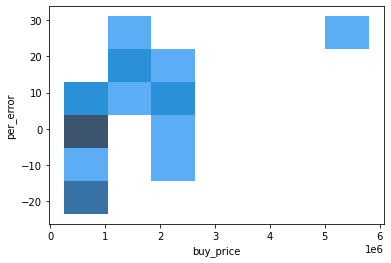

In [65]:
sns.histplot(x=final_df["buy_price"], y=final_df["per_error"])

<AxesSubplot:xlabel='buy_price', ylabel='per_abs_error'>

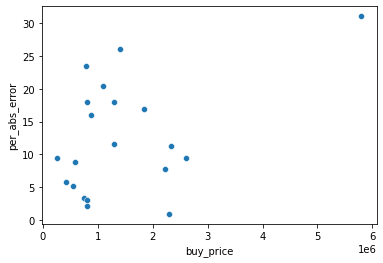

In [66]:
sns.scatterplot(x=final_df["buy_price"], y=final_df["per_abs_error"])

#### Now let's test old 200 apartments:

In [9]:
df_old = pd.read_csv("./data/dfs_retrain/df_final_pred.csv")

In [10]:
saved_model = h2o.load_model("./models/GBM_grid__1_AutoML_20210728_185537_model_16")

In [14]:
df_old = df_old.rename(columns = {
"house_type": "house_type_id"
   })

In [15]:
h2o_df_old = h2o.H2OFrame(df_old)
predictions_old = saved_model.predict(h2o_df_old)
h2o_df_old["prediction"] = predictions_old

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [16]:
old_df = h2o_df_old.as_data_frame()
old_df["buy_prediction"] = 10**old_df.prediction
old_df = old_df.astype({"buy_prediction": int})

In [17]:
old_df["error"] = old_df["buy_price"] - old_df["buy_prediction"]
old_df["abs_error"] = abs(old_df["buy_price"] - old_df["buy_prediction"])
old_df["per_error"] = (old_df["error"] / old_df["buy_price"]) * 100
old_df["per_abs_error"] = (old_df["abs_error"] / old_df["buy_price"]) * 100
old_df["good_purchase"] = old_df["error"] < 0

In [20]:
cols = ["buy_price", "prediction", "error", "per_error", "good_purchase", "abs_error", "per_abs_error", "buy_prediction"]
old_df[cols].sample(5)

,buy_price,prediction,error,per_error,good_purchase,abs_error,per_abs_error,buy_prediction
132,2300000,6.301944,295787,12.860304,False,295787,12.860304,2004213
68,598000,5.761272,20873,3.490468,False,20873,3.490468,577127
84,2340000,6.317261,263841,11.275256,False,263841,11.275256,2076159
177,550000,5.709971,37173,6.758727,False,37173,6.758727,512827
50,770000,5.907297,-37787,-4.907403,True,37787,4.907403,807787


In [21]:
old_df.per_abs_error.mean()

9.20848754158024

<AxesSubplot:xlabel='buy_price', ylabel='per_error'>

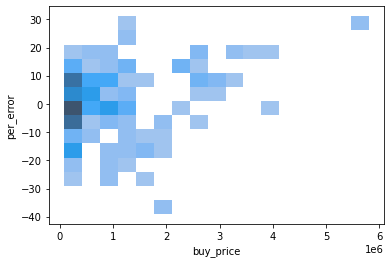

In [22]:
sns.histplot(x=old_df["buy_price"], y=old_df["per_error"])

<AxesSubplot:xlabel='buy_price', ylabel='per_abs_error'>

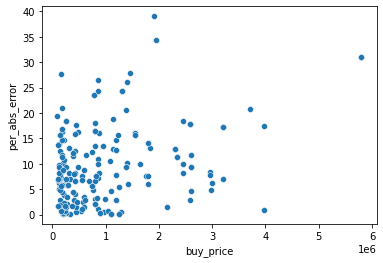

In [23]:
sns.scatterplot(x=old_df["buy_price"], y=old_df["per_abs_error"])